#Resume Classification


##Importing Required Libraries

In [1]:
# Install required system packages for .doc reading
!pip install pip==23.3.2 --quiet
!sudo apt-get install -y antiword unrtf

# Install required Python packages
!pip install python-docx pdfplumber PyMuPDF tqdm --quiet
!pip install nltk wordcloud seaborn spacy --quiet

# Download SpaCy model
!python -m spacy download en_core_web_sm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  antiword unrtf
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 163 kB of archives.
After this operation, 754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 antiword amd64 0.37-16 [118 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 unrtf amd64 0.21.10-clean-1 [45.0 kB]
Fetched 163 kB in 1s (308 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling 

In [2]:
# System & utilities
import os
import re
import warnings
warnings.filterwarnings('ignore')

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from matplotlib import pylab

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

# SpaCy
import spacy

# Text processing
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# OCR / text extraction
# import textract # Removed as it was causing dependency conflicts and not being used

In [3]:
from google.colab import files
uploaded_doc_files = files.upload()

Saving Resumes_Docx.zip to Resumes_Docx.zip


In [4]:
import zipfile
with zipfile.ZipFile("Resumes_Docx.zip", "r") as z:
    z.extractall("Resumes")

In [5]:
os.listdir('Resumes/Resumes_Docx')

['React Developer',
 'Peoplesoft',
 'SQL Developer',
 'workday',
 'Peoplesoft Resume']

In [6]:
!ls /content/Resumes/

Resumes_Docx


In [7]:
file_path   = r'Resumes/Resumes_Docx'
doc_file    = []
pdf_file    = []
docx_file   = []
folder_name = []

for folder in os.listdir(file_path):
    folder_path = os.path.join(file_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.doc'):
            doc_file.append(file)
            folder_name.append(folder)
        elif file.endswith('.docx'):
            docx_file.append(file)
            folder_name.append(folder)
        else:
            pdf_file.append(file)
            folder_name.append(folder)

In [8]:
print('Number of .doc Files  = {}'.format(len(doc_file)),'\n'
      'Number of .pdf Files  = {}'.format(len(pdf_file)),'\n'
      'Number of .docx Files = {}'.format(len(docx_file)))

Number of .doc Files  = 26 
Number of .pdf Files  = 1 
Number of .docx Files = 53


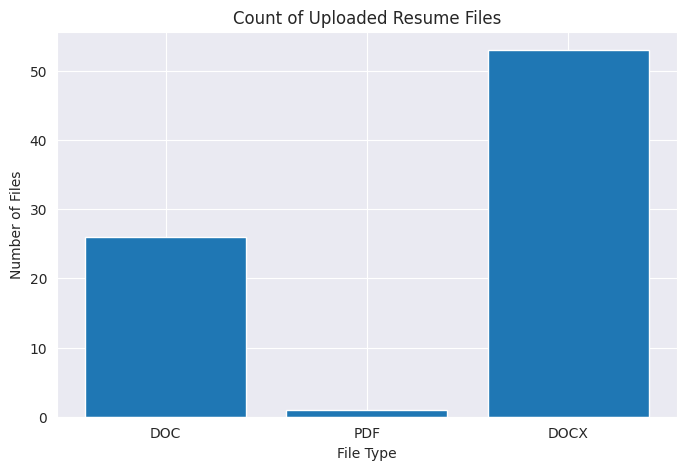

In [9]:
import matplotlib.pyplot as plt

# File counts
counts = {
    'DOC': len(doc_file),
    'PDF': len(pdf_file),
    'DOCX': len(docx_file)
}

# Create bar plot
plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values())
plt.xlabel("File Type")
plt.ylabel("Number of Files")
plt.title("Count of Uploaded Resume Files")
plt.show()


In [10]:
import os

# Move the uploaded .doc files to the Nlp folder
for filename in uploaded_doc_files.keys():
    if filename.endswith('.doc'):
        # Construct the full path to the destination
        destination_path = os.path.join('/content/Resumes/Resumes_Docx/', filename)
        # Move the file
        os.rename(filename, destination_path)
        print(f"Moved {filename} to {destination_path}")

In [11]:
import pdfplumber
import docx
import subprocess

def read_pdf(path):
    text = ""
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text

def read_docx(path):
    try:
        document = docx.Document(path)
        return "\n".join([para.text for para in document.paragraphs])
    except Exception as e:
        print(f"Warning: Could not read docx file {path}. Error: {e}")
        return ""

def read_doc(path):
    try:
        # Use antiword via subprocess to read .doc files
        result = subprocess.run(['antiword', path], capture_output=True, text=True, check=True)
        return result.stdout
    except Exception as e:
        print(f"Warning: Could not read doc file {path}. Error: {e}")
        return ""

In [12]:
import os
from tqdm import tqdm

base_resume_path = "/content/Resumes/Resumes_Docx/"  # The main directory containing subfolders

data = []

# Iterate through each category folder (e.g., 'React Developer', 'SQL Developer')
for folder_category in os.listdir(base_resume_path):
    category_path = os.path.join(base_resume_path, folder_category)

    # Ensure it's a directory before trying to list its contents
    if os.path.isdir(category_path):
        # Iterate through each file within the category folder with tqdm for progress
        for file_name in tqdm(os.listdir(category_path), desc=f"Processing {folder_category}"):
            full_file_path = os.path.join(category_path, file_name)

            text = ""
            if file_name.endswith(".pdf"):
                text = read_pdf(full_file_path)
            elif file_name.endswith(".docx"):
                text = read_docx(full_file_path)
            elif file_name.endswith(".doc"):
                text = read_doc(full_file_path)
            else:
                # Skip files with unsupported extensions
                continue

            # Append the extracted text, filename, and category to the data list
            data.append({"profiles": folder_category, "filename": file_name, "text": text})

Processing Peoplesoft: 100%|██████████| 1/1 [00:00<00:00, 826.30it/s]


Processing Peoplesoft Resume: 100%|██████████| 20/20 [00:00<00:00, 74.96it/s]


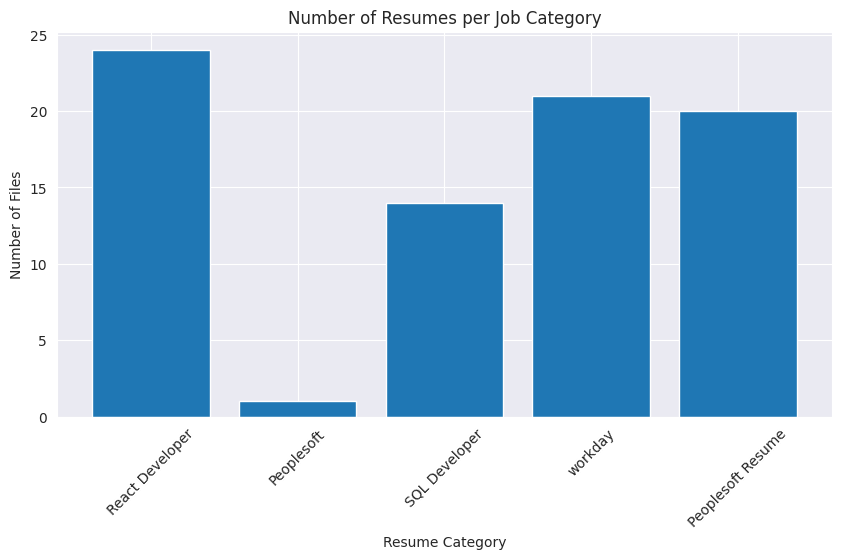

In [13]:
import os
import matplotlib.pyplot as plt

base_resume_path = "/content/Resumes/Resumes_Docx/"

category_names = []
category_counts = []

for folder in os.listdir(base_resume_path):
    folder_path = os.path.join(base_resume_path, folder)
    if os.path.isdir(folder_path):
        category_names.append(folder)
        category_counts.append(len(os.listdir(folder_path)))

plt.figure(figsize=(10,5))
plt.bar(category_names, category_counts)
plt.xticks(rotation=45)
plt.xlabel("Resume Category")
plt.ylabel("Number of Files")
plt.title("Number of Resumes per Job Category")
plt.show()


In [14]:
import pandas as pd

df = pd.DataFrame(data)
df.head()

,profiles,filename,text
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...


In [15]:
df.shape

(80, 3)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   profiles  80 non-null     object
 1   filename  80 non-null     object
 2   text      80 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


In [17]:
df.describe()

,profiles,filename,text
count,80,80,80
unique,5,80,80
top,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...
freq,24,1,1


**EDA**

In [18]:
print("rows:", df.shape[0])
print("missing text:", df['text'].isna().sum())
df["text_length"] = df["text"].apply(lambda x: len(str(x)))
df.head()


rows: 80
missing text: 0


,profiles,filename,text,text_length
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633


In [19]:
print("Longest Resumes:")
display(df.nlargest(5, "text_length")[["filename","text_length"]])

print("Shortest Resumes:")
display(df.nsmallest(5, "text_length")[["filename","text_length"]])

Longest Resumes:


,filename,text_length
7,React JS Developer_AnjaniPriyadarshini.doc,35202
67,Peoplesoft Admin_srinivasarao.doc,21007
69,Peoplesoft Admin_Vinod Akkala.doc,16983
76,PeopleSoft DBA_Vivekanand Sayana.docx,15339
46,ShireeshKumar_Hexaware.doc,12986


Shortest Resumes:


,filename,text_length
24,Peoplesoft Admin_G Ananda Rayudu.docx,0
22,React Developer_Thirupathiamma.docx,994
10,Reactjs Developer_Shaik Abdul Sharuk_Musquare ...,1440
5,React Developer_Naveen sadhu.docx,1450
23,Reactjs Developer_Pranish Sonone_Musquare Tech...,1548


In [20]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df[['filename','word_count']].head()

,filename,word_count
0,React Dev_Krishna Kanth_Musquare Technologies....,521
1,React Developer_PavasGoswami.doc,580
2,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,786
3,Internship_Susovan Bag_Musquare Technologies.docx,184
4,React Dev_Krishna Kanth.docx,521


In [21]:
df[df['filename'] == 'Peoplesoft Admin_G Ananda Rayudu.docx']

,profiles,filename,text,text_length,word_count
24,Peoplesoft,Peoplesoft Admin_G Ananda Rayudu.docx,,0,0


In [22]:
# Remove rows where 'text' is an empty string (after stripping whitespace)
df = df[df['text'].apply(lambda x: str(x).strip() != '')]

In [23]:
total_words = df['word_count'].sum()
total_words

np.int64(56809)

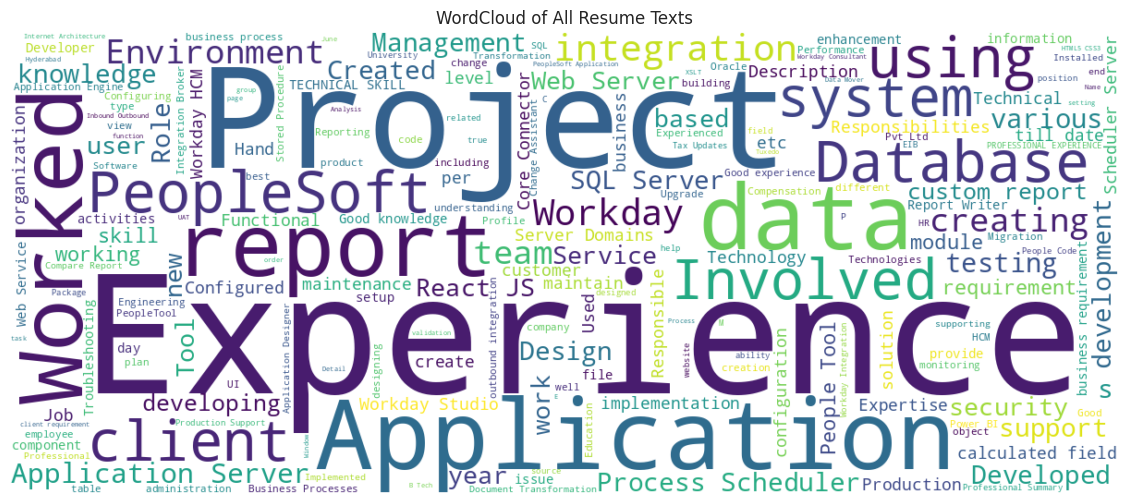

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_combined = " ".join(df["text"])

wc = WordCloud(width=1200, height=500, background_color="white").generate(text_combined)

plt.figure(figsize=(15,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of All Resume Texts")
plt.show()

In [25]:
!pip install nltk
!pip install -q nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # Download the missing punkt_tab resource


# imports
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenization


In [26]:
import nltk
from nltk.tokenize import word_tokenize

# Apply the function to the 'text' column of the DataFrame
df['tokenization'] = df['text'].astype(str).apply(word_tokenize)
df.head()

,profiles,filename,text,text_length,word_count,tokenization
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,..."
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo..."
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant..."
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi..."
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,..."


Normalization


In [27]:
def to_lowercase(tokenization):
    return [t.lower() for t in tokenization]

df["Normalization"] = df["tokenization"].apply(to_lowercase)
df.head()


,profiles,filename,text,text_length,word_count,tokenization,Normalization
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,..."
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo...","[[, pic, ], profile, searching, for, the, oppo..."
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant...","[kotani, durga, prasad, objective, :, aspirant..."
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi...","[susovan, bag, seeking, a, challenging, positi..."
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,..."


Stop words

In [28]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
def remove_stop(Normalization):
    return [t for t in Normalization if t.lower() not in stopwords_list]

df["stopwordss"] = df["Normalization"].apply(remove_stop)
df.head()

,profiles,filename,text,text_length,word_count,tokenization,Normalization,stopwordss
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,..."
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo...","[[, pic, ], profile, searching, for, the, oppo...","[[, pic, ], profile, searching, opportunity, b..."
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, :, aspirant..."
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi...","[susovan, bag, seeking, a, challenging, positi...","[susovan, bag, seeking, challenging, position,..."
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,..."


Punctuation Removal

In [29]:
import re

def remove_punct(words):
    cleaned = []
    for w in words:
        # remove punctuation & digits inside the token
        w2 = re.sub(r'[^a-zA-Z]', '', w)   # keep only letters
        if w2 != '':
            cleaned.append(w2)
    return cleaned
df["punc"] = df["stopwordss"].apply(remove_punct)
df.head()


,profiles,filename,text,text_length,word_count,tokenization,Normalization,stopwordss,punc
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris..."
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo...","[[, pic, ], profile, searching, for, the, oppo...","[[, pic, ], profile, searching, opportunity, b...","[pic, profile, searching, opportunity, bring, ..."
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, aspirant, p..."
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi...","[susovan, bag, seeking, a, challenging, positi...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seeking, challenging, position,..."
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris..."


Stemming


In [30]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def stem_words(tokens):
    return [porter.stem(word) for word in tokens]

df["stems"] = df["punc"].apply(stem_words)
df.head()


,profiles,filename,text,text_length,word_count,tokenization,Normalization,stopwordss,punc,stems
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris...","[uidevelop, react, js, develop, name, krishna,..."
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo...","[[, pic, ], profile, searching, for, the, oppo...","[[, pic, ], profile, searching, opportunity, b...","[pic, profile, searching, opportunity, bring, ...","[pic, profil, search, opportun, bring, year, e..."
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, aspirant, p...","[kotani, durga, prasad, object, aspir, posit, ..."
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi...","[susovan, bag, seeking, a, challenging, positi...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seek, challeng, posit, field, s..."
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris...","[uidevelop, react, js, develop, name, krishna,..."


Lemmatization

In [31]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

df["lemmas"] = df["punc"].apply(lemmatize_tokens)
df.head()


,profiles,filename,text,text_length,word_count,tokenization,Normalization,stopwordss,punc,stems,lemmas
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris...","[uidevelop, react, js, develop, name, krishna,...","[uideveloper, react, j, developer, name, krish..."
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo...","[[, pic, ], profile, searching, for, the, oppo...","[[, pic, ], profile, searching, opportunity, b...","[pic, profile, searching, opportunity, bring, ...","[pic, profil, search, opportun, bring, year, e...","[pic, profile, searching, opportunity, bring, ..."
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, aspirant, p...","[kotani, durga, prasad, object, aspir, posit, ...","[kotani, durga, prasad, objective, aspirant, p..."
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi...","[susovan, bag, seeking, a, challenging, positi...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seek, challeng, posit, field, s...","[susovan, bag, seeking, challenging, position,..."
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris...","[uidevelop, react, js, develop, name, krishna,...","[uideveloper, react, j, developer, name, krish..."


In [32]:
total_words_before_cleaning = df['word_count'].sum()
total_words_after_cleaning = df['punc'].apply(len).sum()


print(f"Total words in all resumes before cleaning: {total_words_before_cleaning}")
print(f"Total words in all resumes after cleaning : {total_words_after_cleaning}")

Total words in all resumes before cleaning: 56809
Total words in all resumes after cleaning : 38851


Total number of words before and after text cleaning.

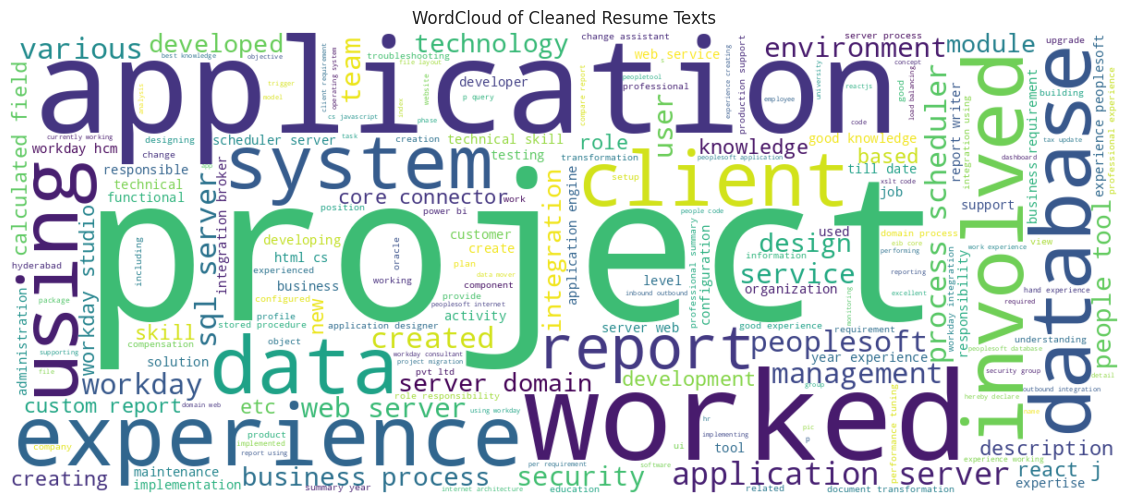

In [33]:

cleaned_text_combined = " ".join([" ".join(tokens) for tokens in df["lemmas"]])


wc = WordCloud(width=1200, height=500, background_color="white").generate(cleaned_text_combined)

plt.figure(figsize=(15,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Cleaned Resume Texts")
plt.show()


In [34]:
df['cleaned_text_string'] = df['lemmas'].apply(lambda x: ' '.join(x))
df.head()

,profiles,filename,text,text_length,word_count,tokenization,Normalization,stopwordss,punc,stems,lemmas,cleaned_text_string
0,React Developer,React Dev_Krishna Kanth_Musquare Technologies....,\nUi-Developer/ React JS Developer \nNAME: KRI...,3634,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris...","[uidevelop, react, js, develop, name, krishna,...","[uideveloper, react, j, developer, name, krish...",uideveloper react j developer name krishna pro...
1,React Developer,React Developer_PavasGoswami.doc,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115,580,"[[, pic, ], PROFILE, Searching, for, the, oppo...","[[, pic, ], profile, searching, for, the, oppo...","[[, pic, ], profile, searching, opportunity, b...","[pic, profile, searching, opportunity, bring, ...","[pic, profil, search, opportun, bring, year, e...","[pic, profile, searching, opportunity, bring, ...",pic profile searching opportunity bring year e...
2,React Developer,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...,5383,786,"[Kotani, Durga, Prasad, Objective, :, Aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, :, aspirant...","[kotani, durga, prasad, objective, aspirant, p...","[kotani, durga, prasad, object, aspir, posit, ...","[kotani, durga, prasad, objective, aspirant, p...",kotani durga prasad objective aspirant positio...
3,React Developer,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184,"[SUSOVAN, BAG, Seeking, a, challenging, positi...","[susovan, bag, seeking, a, challenging, positi...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seeking, challenging, position,...","[susovan, bag, seek, challeng, posit, field, s...","[susovan, bag, seeking, challenging, position,...",susovan bag seeking challenging position field...
4,React Developer,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521,"[Ui-Developer/, React, JS, Developer, NAME, :,...","[ui-developer/, react, js, developer, name, :,...","[ui-developer/, react, js, developer, name, :,...","[uideveloper, react, js, developer, name, kris...","[uidevelop, react, js, develop, name, krishna,...","[uideveloper, react, j, developer, name, krish...",uideveloper react j developer name krishna pro...


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1)) # To capture unigrams
X = vectorizer.fit_transform(df['cleaned_text_string'])

print("CountVectorizer fitted and transformed the text data.")

CountVectorizer fitted and transformed the text data.


In [36]:
feature_names = vectorizer.get_feature_names_out()
unigram_counts = X.sum(axis=0)
unigram_df = pd.DataFrame({'unigram': feature_names, 'count': unigram_counts.tolist()[0]})
top_20_unigrams = unigram_df.sort_values(by='count', ascending=False).head(20)

print("Top 20 most frequent unigrams:")
print(top_20_unigrams)

Top 20 most frequent unigrams:
          unigram  count
1338   experience    582
214   application    506
3375       server    482
3146       report    458
2718   peoplesoft    433
4159      workday    390
3983        using    383
2919      project    362
1915  integration    361
929          data    319
2889      process    286
930      database    286
506      business    263
3699       system    250
4108          web    224
3534          sql    218
3833         tool    218
4163       worked    218
643        client    211
2058    knowledge    206


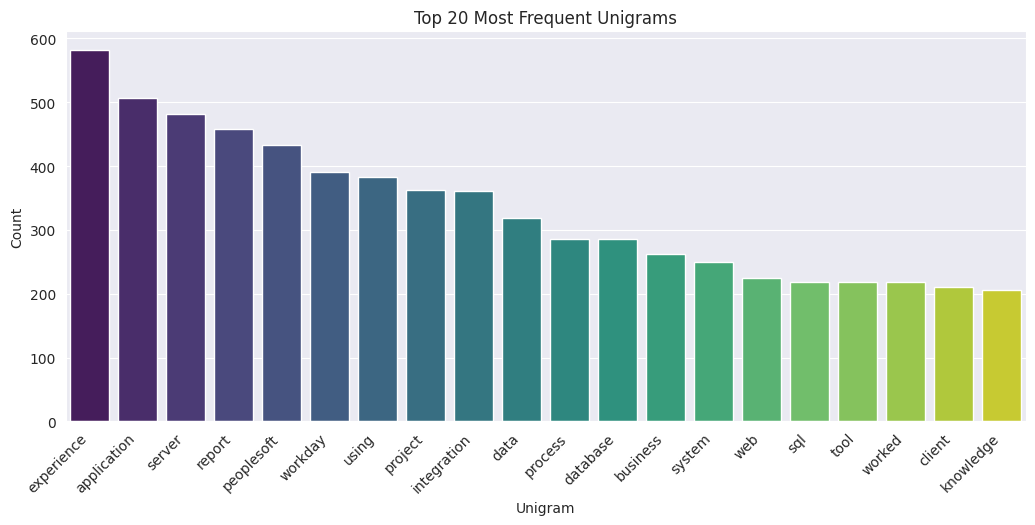

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x='unigram', y='count', data=top_20_unigrams, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Count')
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.25)
plt.show()

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2)) # To capture unigrams
X = vectorizer.fit_transform(df['cleaned_text_string'])


In [39]:
feature_names = vectorizer.get_feature_names_out()
bigram_counts = X.sum(axis=0)
bigram_df = pd.DataFrame({'bigram': feature_names, 'count': bigram_counts.tolist()[0]})
top_20_bigrams = bigram_df.sort_values(by='count', ascending=False).head(20)

print("Top 20 most frequent bigrams:")
print(top_20_bigrams)

Top 20 most frequent bigrams:
                      bigram  count
869       application server    119
13176      process scheduler    106
16465             sql server    102
19382             web server     89
1982        business process     82
12298            people tool     78
15623          server domain     75
3846           custom report     74
2018        calculated field     70
3418          core connector     68
19713         workday studio     66
17892              till date     64
20132        year experience     61
8046                 html cs     60
19681            workday hcm     59
15263       scheduler server     56
7473          good knowledge     53
1986    business requirement     51
19383            web service     50
6407   experience peoplesoft     49


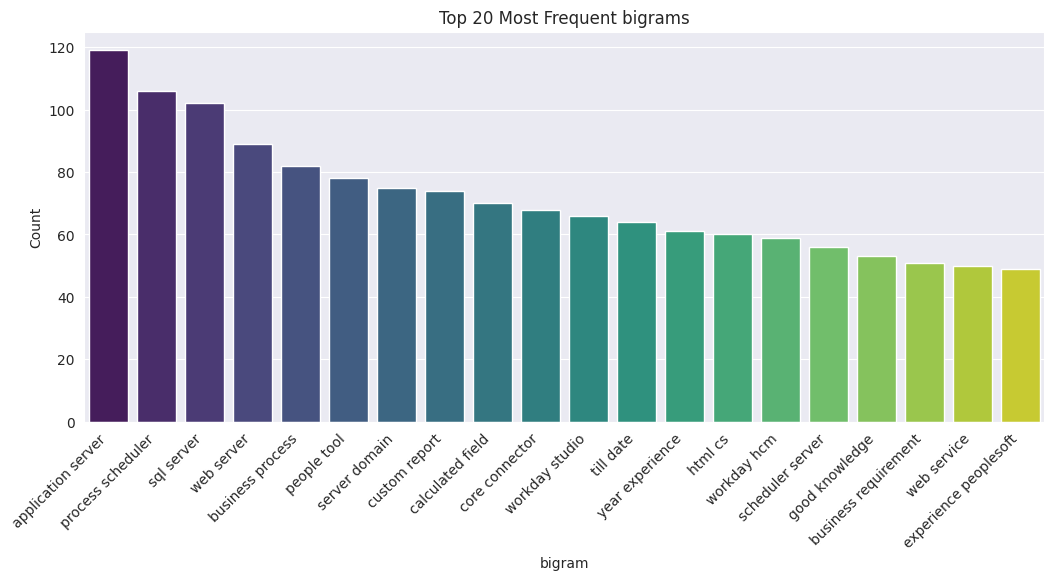

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(x='bigram', y='count', data=top_20_bigrams, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent bigrams')
plt.xlabel('bigram')
plt.ylabel('Count')
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.25)
plt.show()

In [41]:
columns_to_drop = [
    'filename',
    'text',
    'text_length',
    'word_count',
    'tokenization',
    'Normalization',
    'stopwordss',
    'punc',
    'stems',
    'lemmas'
]
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,profiles,cleaned_text_string
0,React Developer,uideveloper react j developer name krishna pro...
1,React Developer,pic profile searching opportunity bring year e...
2,React Developer,kotani durga prasad objective aspirant positio...
3,React Developer,susovan bag seeking challenging position field...
4,React Developer,uideveloper react j developer name krishna pro...


Label Encoding

In [42]:
from sklearn.preprocessing import LabelEncoder
Encoder=LabelEncoder()
df["LabelEncoding"]=Encoder.fit_transform(df["profiles"])
df

,profiles,cleaned_text_string,LabelEncoding
0,React Developer,uideveloper react j developer name krishna pro...,1
1,React Developer,pic profile searching opportunity bring year e...,1
2,React Developer,kotani durga prasad objective aspirant positio...,1
3,React Developer,susovan bag seeking challenging position field...,1
4,React Developer,uideveloper react j developer name krishna pro...,1
...,...,...,...
75,Peoplesoft Resume,career objective pursuing peoplesoft executive...,0
76,Peoplesoft Resume,peoplesoft administration vivekanand sayana ca...,0
77,Peoplesoft Resume,priyanka ramadoss mountpleasant coonoor nilgir...,0
78,Peoplesoft Resume,c n c address manyata tech park nagavara banga...,0


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x = df['cleaned_text_string'].values
y = df['profiles'].values

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=45, test_size=0.3,stratify=y)
x_train.shape, x_test.shape

((55,), (24,))

TF-IDF Vectorization

In [44]:
# Clean reset
x = df['cleaned_text_string'].astype(str).values
y = df['profiles'].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=45, stratify=y
)

# Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    ngram_range=(1,2),
    min_df=2
)


In [45]:
x_train = tfidf.fit_transform(x_train)
x_test  = tfidf.transform(x_test)

print(x_train.shape, x_test.shape)

(55, 4287) (24, 4287)


MODEL BUILDING

In [46]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt


Decision Tree Classifier

In [47]:
model_DT = DecisionTreeClassifier(criterion='gini')
model_DT.fit(x_train, y_train)
y_pred = model_DT.predict(x_test)
accuracy_DT = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_DT.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_DT.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 1.00
Accuracy of  test set    : 0.92
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         6
  React Developer       1.00      0.71      0.83         7
    SQL Developer       0.67      1.00      0.80         4
          workday       1.00      1.00      1.00         7

         accuracy                           0.92        24
        macro avg       0.92      0.93      0.91        24
     weighted avg       0.94      0.92      0.92        24



KNN Classifier

In [48]:
model_knn = KNeighborsClassifier(n_neighbors=41)
model_knn.fit(x_train, y_train)
y_pred = model_knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_knn.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_knn.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 0.76
Accuracy of  test set    : 0.83
                   precision    recall  f1-score   support

Peoplesoft Resume       0.86      1.00      0.92         6
  React Developer       0.88      1.00      0.93         7
    SQL Developer       0.00      0.00      0.00         4
          workday       0.78      1.00      0.88         7

         accuracy                           0.83        24
        macro avg       0.63      0.75      0.68        24
     weighted avg       0.70      0.83      0.76        24



Random Forest Classifier

In [49]:
model_RF = RandomForestClassifier(n_estimators=200)
model_RF.fit(x_train, y_train)
y_pred = model_RF.predict(x_test)
accuracy_RF = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_RF.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_RF.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 1.00
Accuracy of  test set    : 1.00
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         6
  React Developer       1.00      1.00      1.00         7
    SQL Developer       1.00      1.00      1.00         4
          workday       1.00      1.00      1.00         7

         accuracy                           1.00        24
        macro avg       1.00      1.00      1.00        24
     weighted avg       1.00      1.00      1.00        24



SVM Classifier

In [50]:
model_svm = SVC()
model_svm.fit(x_train, y_train)
y_pred = model_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_svm.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_svm.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_svm,classification_report(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 1.00
Accuracy of  test set    : 0.96
Classification report for classifier SVC():
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      0.83      0.91         6
  React Developer       0.88      1.00      0.93         7
    SQL Developer       1.00      1.00      1.00         4
          workday       1.00      1.00      1.00         7

         accuracy                           0.96        24
        macro avg       0.97      0.96      0.96        24
     weighted avg       0.96      0.96      0.96        24


                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      0.83      0.91         6
  React Developer       0.88      1.00      0.93         7
    SQL Developer       1.00      1.00      1.00         4
          workday       1.00      1.00      1.00         7

         accuracy                           0.96        24
        macro avg       0.97      0.96      0.96        24
 

Logistic Regression

In [51]:
model_lgr = LogisticRegression()
model_lgr.fit(x_train, y_train)
y_pred = model_lgr.predict(x_test)
accuracy_lgr = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_lgr.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_lgr.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 1.00
Accuracy of  test set    : 1.00
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         6
  React Developer       1.00      1.00      1.00         7
    SQL Developer       1.00      1.00      1.00         4
          workday       1.00      1.00      1.00         7

         accuracy                           1.00        24
        macro avg       1.00      1.00      1.00        24
     weighted avg       1.00      1.00      1.00        24



Bagging Classifier

In [52]:
model_bagg = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
model_bagg.fit(x_train, y_train)
y_pred = model_bagg.predict(x_test)
accuracy_bagg = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_bagg.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_bagg.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 1.00
Accuracy of  test set    : 1.00
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         6
  React Developer       1.00      1.00      1.00         7
    SQL Developer       1.00      1.00      1.00         4
          workday       1.00      1.00      1.00         7

         accuracy                           1.00        24
        macro avg       1.00      1.00      1.00        24
     weighted avg       1.00      1.00      1.00        24



Naive Bayes Classifier

In [53]:
model_NB =MultinomialNB(alpha=1, fit_prior=False, class_prior=None)
model_NB.fit(x_train, y_train)
y_pred = model_NB.predict(x_test)
accuracy_NB = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_NB.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_NB.score(x_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of training set : 1.00
Accuracy of  test set    : 1.00
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         6
  React Developer       1.00      1.00      1.00         7
    SQL Developer       1.00      1.00      1.00         4
          workday       1.00      1.00      1.00         7

         accuracy                           1.00        24
        macro avg       1.00      1.00      1.00        24
     weighted avg       1.00      1.00      1.00        24



Model Performance Summary

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Dictionary to store model objects
models = {
    "Decision Tree": DecisionTreeClassifier(criterion='gini'),
    "KNN": KNeighborsClassifier(n_neighbors=41),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Bagging Classifier": BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    "Naive Bayes": MultinomialNB(alpha=1, fit_prior=False)
}

# Empty list to store results
results = []

# Loop through all models
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    train_acc = round(model.score(x_train, y_train), 2)
    test_acc = round(accuracy_score(y_test, y_pred), 2)

    results.append([name, train_acc, test_acc])

# Convert to DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Model", "Train Accuracy", "Test Accuracy"]
)

# Display results
print(results_df)


                 Model  Train Accuracy  Test Accuracy
0        Decision Tree            1.00           0.88
1                  KNN            0.76           0.83
2        Random Forest            1.00           1.00
3                  SVM            1.00           0.96
4  Logistic Regression            1.00           1.00
5   Bagging Classifier            1.00           1.00
6          Naive Bayes            1.00           1.00


In [55]:
# Single cell: Confusion matrices + Cross-validation summary for all models (with Train & Test Accuracy)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


models = {
    "Decision Tree": DecisionTreeClassifier(criterion='gini', random_state=45),
    "KNN": KNeighborsClassifier(n_neighbors=41),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=45),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=45),
    "Bagging (KNN)": BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, random_state=45),
    "Naive Bayes": MultinomialNB(alpha=1, fit_prior=False)
}

# Prepare results storage
cv_results = {}
eval_results = []

# Class labels for confusion matrix
class_labels = np.unique(y_test)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

for name, model in models.items():
    print(f"\n=== {name} ===")

    # Fit model
    model.fit(x_train, y_train)

    # Train and Test Predictions
    y_train_pred = model.predict(x_train)
    y_pred = model.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy: {test_acc:.4f}")




    # Cross-validation
    try:
        scores = cross_val_score(model, x_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
        cv_mean = scores.mean()
        cv_std = scores.std()
        cv_results[name] = scores
        print(f"Cross-val Accuracies: {np.round(scores,4)}")
        print(f"CV Mean Accuracy: {cv_mean:.4f}  |  Std: {cv_std:.4f}")
    except Exception as e:
        cv_results[name] = None
        print(f"Cross-validation error for {name}: {e}")





=== Decision Tree ===
Test Accuracy: 0.8750
Cross-val Accuracies: [0.8182 1.     1.     0.9091 1.    ]
CV Mean Accuracy: 0.9455  |  Std: 0.0727

=== KNN ===
Test Accuracy: 0.8333
Cross-val Accuracies: [0.5455 0.5455 0.5455 0.4545 0.5455]
CV Mean Accuracy: 0.5273  |  Std: 0.0364

=== Random Forest ===
Test Accuracy: 0.9583
Cross-val Accuracies: [1.     1.     1.     0.9091 1.    ]
CV Mean Accuracy: 0.9818  |  Std: 0.0364

=== SVM ===
Test Accuracy: 0.9583
Cross-val Accuracies: [0.9091 0.9091 1.     0.8182 1.    ]
CV Mean Accuracy: 0.9273  |  Std: 0.0680

=== Logistic Regression ===
Test Accuracy: 1.0000
Cross-val Accuracies: [1.     1.     1.     0.8182 1.    ]
CV Mean Accuracy: 0.9636  |  Std: 0.0727

=== Bagging (KNN) ===
Test Accuracy: 0.9583
Cross-val Accuracies: [1.     1.     1.     0.9091 1.    ]
CV Mean Accuracy: 0.9818  |  Std: 0.0364

=== Naive Bayes ===
Test Accuracy: 1.0000
Cross-val Accuracies: [1.     1.     1.     0.9091 1.    ]
CV Mean Accuracy: 0.9818  |  Std: 0.0364



=== Decision Tree ===


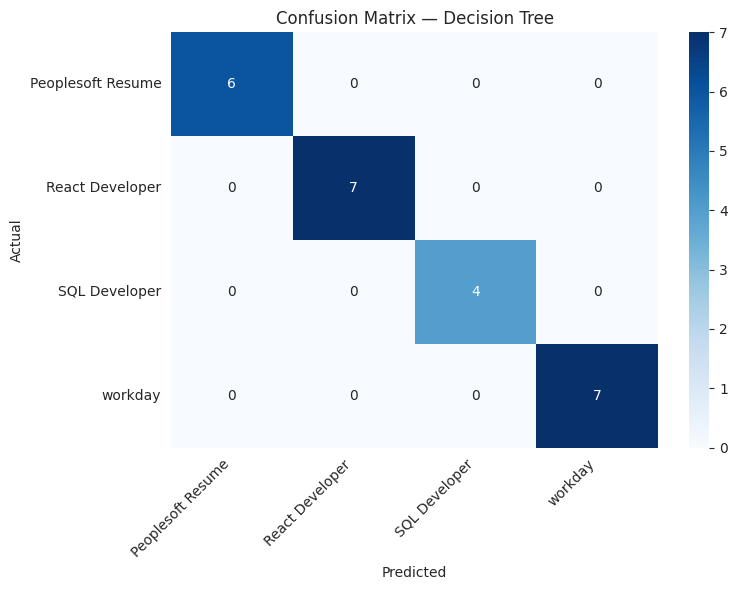


=== KNN ===


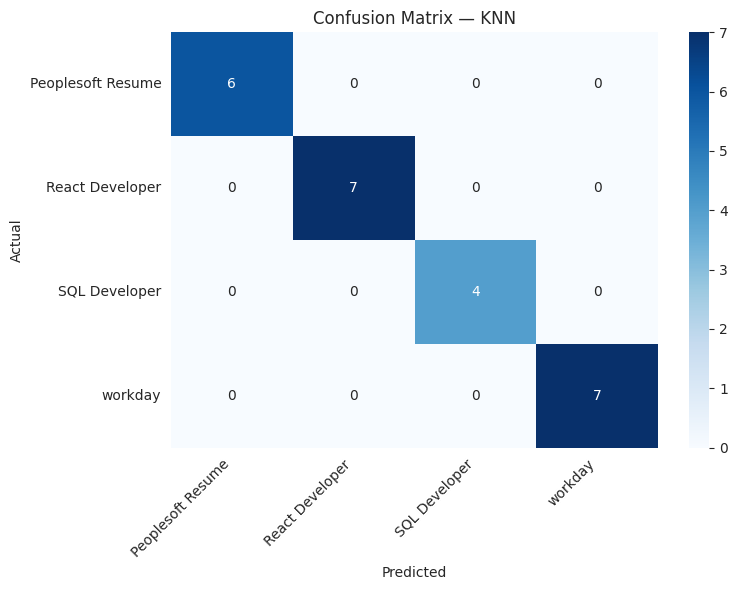


=== Random Forest ===


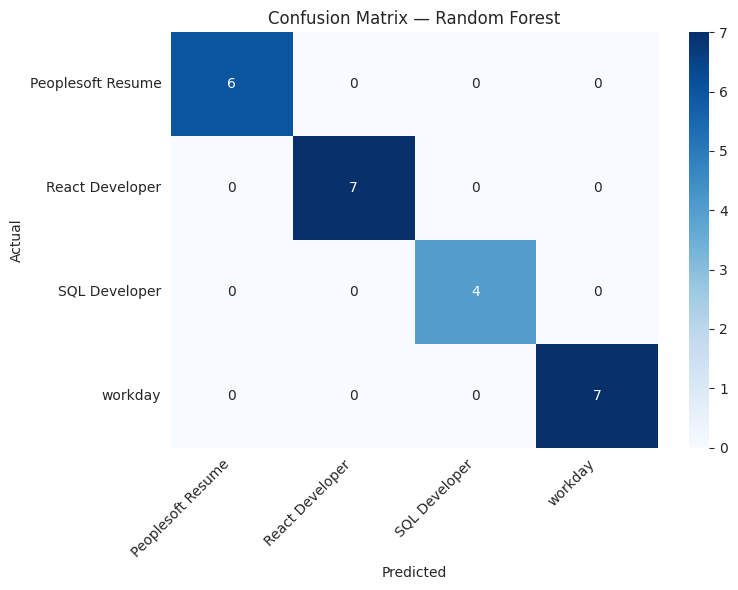


=== SVM ===


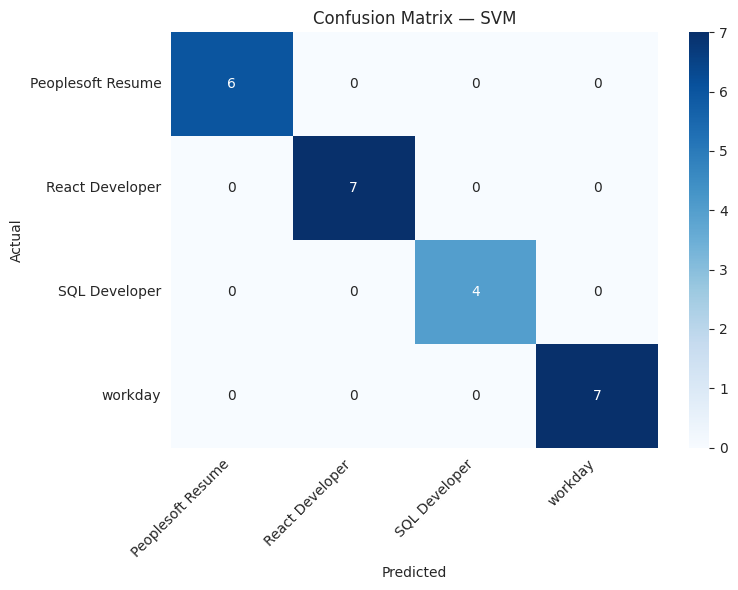


=== Logistic Regression ===


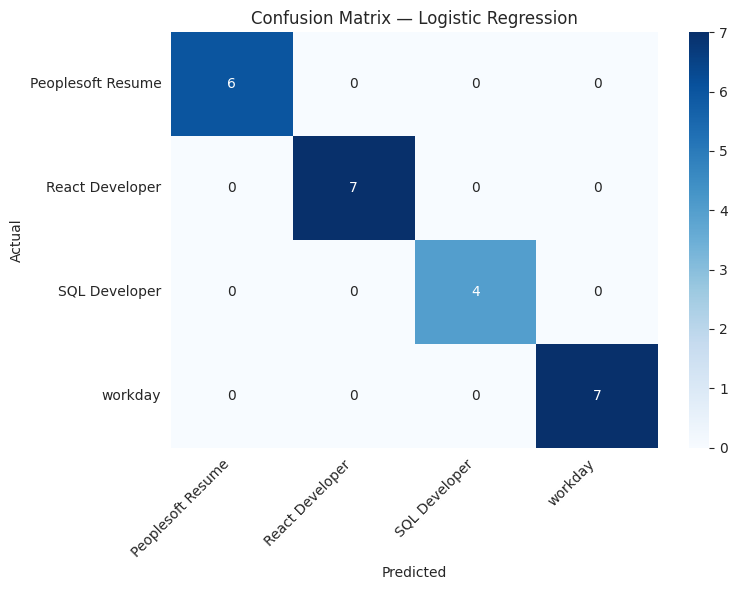


=== Bagging (KNN) ===


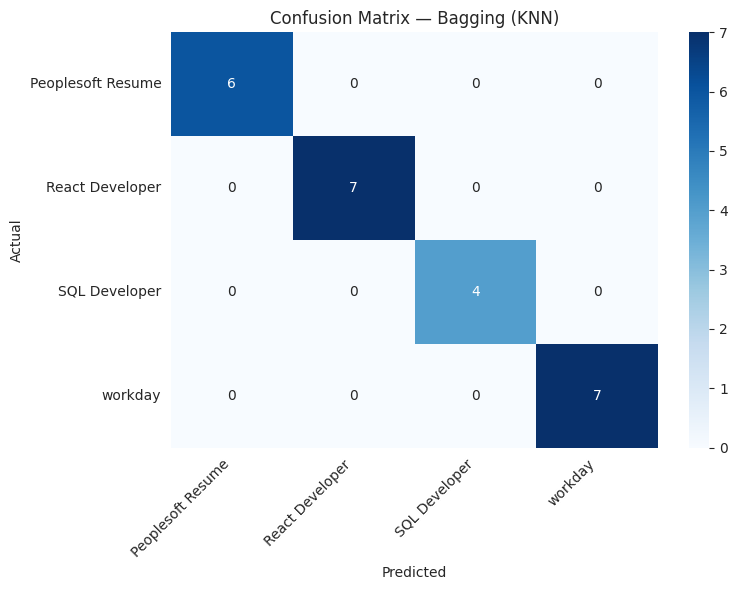


=== Naive Bayes ===


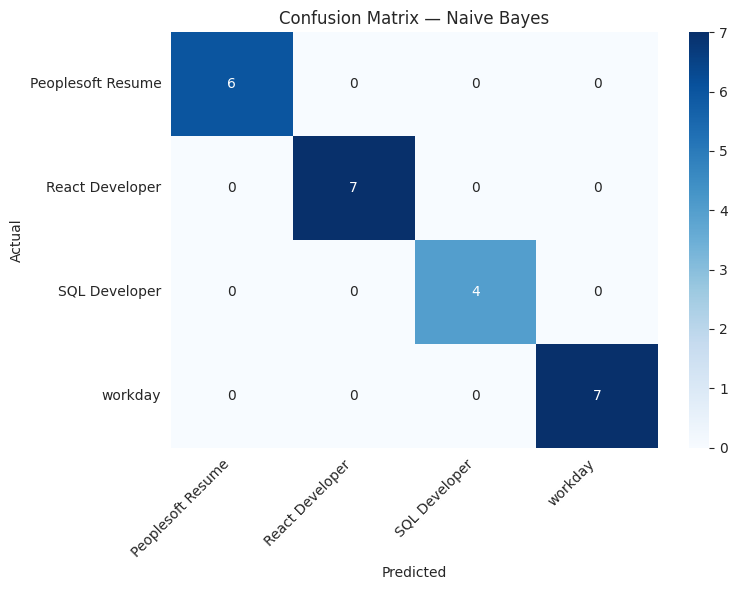

In [56]:
 # Confusion matrix
 for name, model in models.items():
    print(f"\n=== {name} ===")
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [57]:
# All cross-val fold-level accuracies
cv_df = pd.DataFrame({k: (v if v is not None else [np.nan]*5) for k, v in cv_results.items()})
cv_df = cv_df.T
cv_df.columns = [f'Fold_{i+1}' for i in range(cv_df.shape[1])]
cv_df.index.name = 'Model'

print("\n=== Cross-validation per-fold accuracies ===")
display(cv_df)


=== Cross-validation per-fold accuracies ===


,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,
Decision Tree,0.818182,1.000000,1.000000,0.909091,1.000000
KNN,0.545455,0.545455,0.545455,0.454545,0.545455
Random Forest,1.000000,1.000000,1.000000,0.909091,1.000000
SVM,0.909091,0.909091,1.000000,0.818182,1.000000
Logistic Regression,1.000000,1.000000,1.000000,0.818182,1.000000
Bagging (KNN),1.000000,1.000000,1.000000,0.909091,1.000000
Naive Bayes,1.000000,1.000000,1.000000,0.909091,1.000000


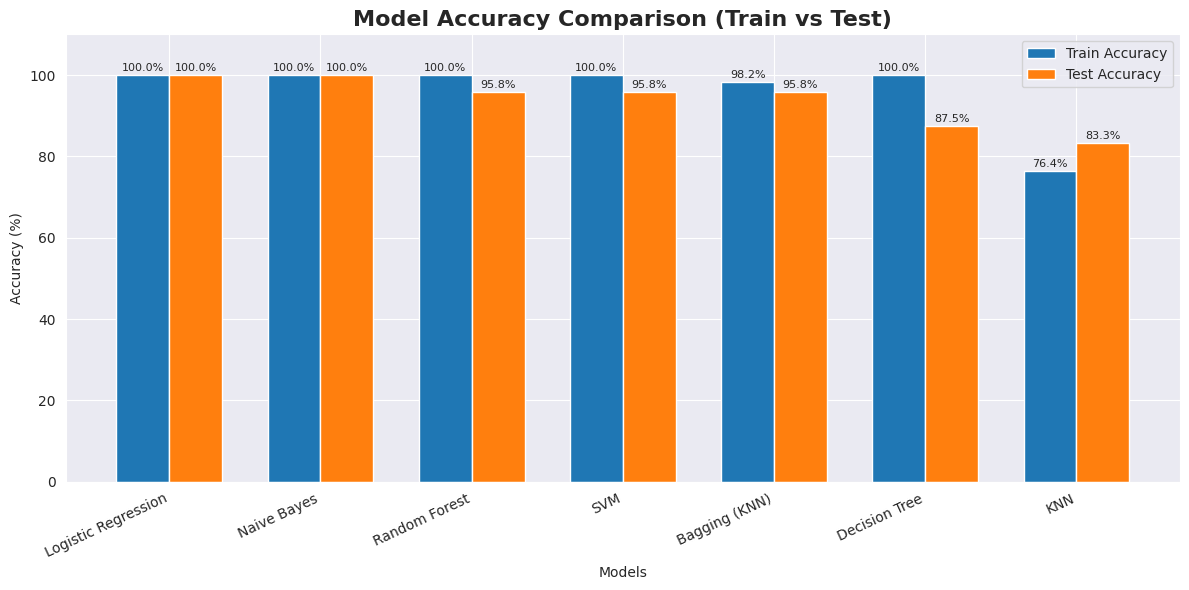

Saved figure to: IMG/model_accuracy_simple.png


In [60]:
# Train vs Test Accuracy Plot

import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure comparison_df exists
assert 'comparison_df' in globals(), "comparison_df not found — run the evaluation cells first."

# Extract data
model_names = comparison_df['Model'].tolist()
train_vals = comparison_df['Train Accuracy'].values * 100
test_vals  = comparison_df['Test Accuracy'].values * 100

# X-axis positions
x = np.arange(len(model_names))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_vals, width, label='Train Accuracy')
plt.bar(x + width/2, test_vals, width, label='Test Accuracy')

# Labels & title
plt.title("Model Accuracy Comparison (Train vs Test)", fontsize=16, fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(x, model_names, rotation=25, ha='right')

# Annotate values
for xpos, val in zip(x - width/2, train_vals):
    plt.text(xpos, val + 1, f"{val:.1f}%", ha='center', fontsize=8)
for xpos, val in zip(x + width/2, test_vals):
    plt.text(xpos, val + 1, f"{val:.1f}%", ha='center', fontsize=8)

# Limits & legend
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()

# Save
os.makedirs("IMG", exist_ok=True)
save_path = "IMG/model_accuracy_simple.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Saved figure to: {save_path}")

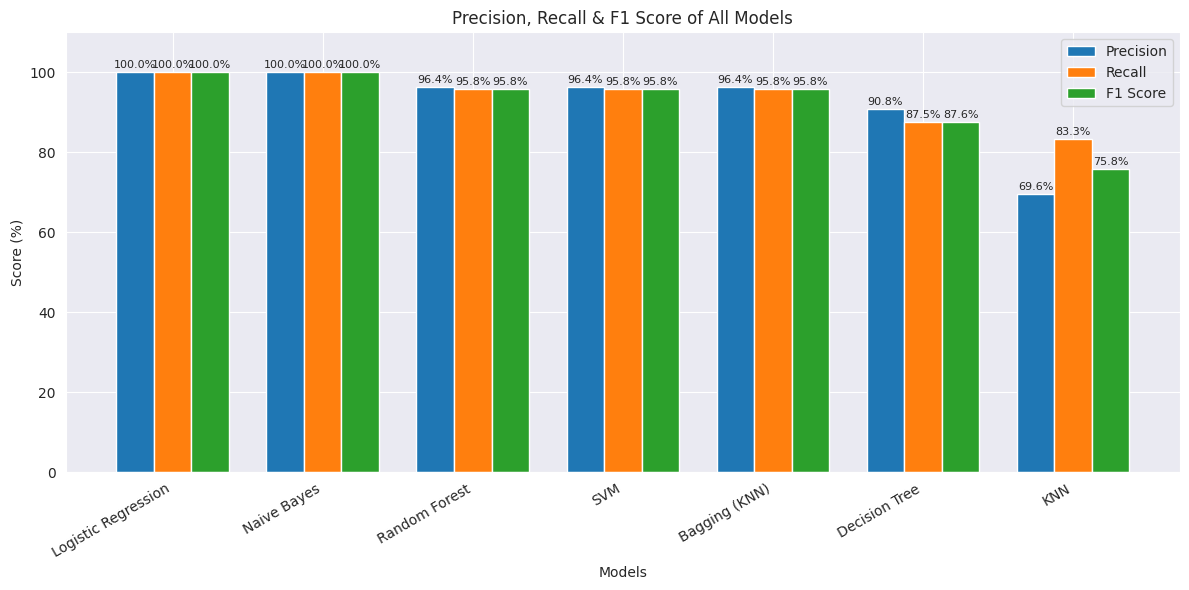

Saved figure to: IMG/model_performance_metrics_simple.png


In [61]:
# Simple Model Performance Metrics Plot (Precision, Recall, F1-Score)

import matplotlib.pyplot as plt
import numpy as np
import os

# Make sure comparison_df exists
assert 'comparison_df' in globals(), "comparison_df not found — run the evaluation cells first."

# Extract values
model_names = comparison_df['Model'].tolist()
precision_vals = comparison_df['Precision (weighted)'].values * 100
recall_vals = comparison_df['Recall (weighted)'].values * 100
f1_vals = comparison_df['F1 Score (weighted)'].values * 100

# X-axis positions
x = np.arange(len(model_names))
width = 0.25

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_vals, width, label='Precision')
plt.bar(x, recall_vals, width, label='Recall')
plt.bar(x + width, f1_vals, width, label='F1 Score')

# Title & axis labels
plt.title("Precision, Recall & F1 Score of All Models")
plt.xlabel("Models")
plt.ylabel("Score (%)")

# X-ticks
plt.xticks(x, model_names, rotation=30, ha='right')

# Add value labels
for xpos, val in zip(x - width, precision_vals):
    plt.text(xpos, val + 1, f"{val:.1f}%", ha='center', fontsize=8)
for xpos, val in zip(x, recall_vals):
    plt.text(xpos, val + 1, f"{val:.1f}%", ha='center', fontsize=8)
for xpos, val in zip(x + width, f1_vals):
    plt.text(xpos, val + 1, f"{val:.1f}%", ha='center', fontsize=8)

plt.ylim(0, 110)
plt.legend()
plt.tight_layout()

# Save
os.makedirs("IMG", exist_ok=True)
save_path = "IMG/model_performance_metrics_simple.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Saved figure to: {save_path}")

In [59]:
# FULL MODEL METRIC COMPARISON

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


# Define all models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=45),
    "KNN": KNeighborsClassifier(n_neighbors=41),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=45),
    "SVM": SVC(random_state=45),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=45),
    "Bagging (KNN)": BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, random_state=45),
    "Naive Bayes": MultinomialNB(alpha=1, fit_prior=False)
}


# Evaluate each model
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

for name, model in models.items():

    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1   = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    # Cross-validation (on training set)
    try:
        cv_scores = cross_val_score(model, x_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
        cv_mean = float(cv_scores.mean())
        cv_std  = float(cv_scores.std())
    except Exception as e:
        cv_mean = np.nan
        cv_std  = np.nan
        print(f"  CV error for {name}: {e}")

    results.append([
        name,
        round(train_acc, 4),
        round(test_acc, 4),
        round(prec, 4),
        round(rec, 4),
        round(f1, 4),
        round(cv_mean, 4) if not np.isnan(cv_mean) else np.nan,
        round(cv_std, 4)  if not np.isnan(cv_std)  else np.nan
    ])


# Build final comparison table

columns = [
    "Model",
    "Train Accuracy",
    "Test Accuracy",
    "Precision (weighted)",
    "Recall (weighted)",
    "F1 Score (weighted)",
    "CV Mean Accuracy",
    "CV Std"
]

comparison_df = pd.DataFrame(results, columns=columns)
comparison_df = comparison_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

print("\n\n============== FINAL METRIC COMPARISON TABLE ==============")
display(comparison_df)





============== FINAL METRIC COMPARISON TABLE ==============


,Model,Train Accuracy,Test Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),CV Mean Accuracy,CV Std
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,0.9636,0.0727
1,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,0.9818,0.0364
2,Random Forest,1.0000,0.9583,0.9635,0.9583,0.9578,0.9818,0.0364
3,SVM,1.0000,0.9583,0.9635,0.9583,0.9578,0.9273,0.0680
4,Bagging (KNN),0.9818,0.9583,0.9635,0.9583,0.9578,0.9818,0.0364
5,Decision Tree,1.0000,0.8750,0.9080,0.8750,0.8759,0.9455,0.0727
6,KNN,0.7636,0.8333,0.6963,0.8333,0.7582,0.5273,0.0364
